# Cancelamento de Clientes - Telco (dataset criado pela IBM para demonstração da ferramenta IBM Cognos Analytics)

### Contém informações sobre uma empresa fictícia de telecomunicações que forneceu serviços de telefonia residencial e internet para 7043 clientes na Califórnia no 3º trimestre.

### Etapa de feature engineering - Realizado por Sabrina Otoni da Silva - 2024/01

### Objetivo: Aplicar técnicas de Feature Engineering no DataFrame.

Nessa etapa, estarei apenas aplicando transformações nos dados com o objetivo de treinar os modelos, sem fazer hipóteses sob os dados, se servirão ou não. A etapa de feature selection estarei deixando para fazer no treinamento de cada modelo, pois isso é muito particular de cada um.

In [1]:
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

import sys
import os

automations_dir = os.path.join(os.getcwd(), '../automations')

if automations_dir not in sys.path:
    sys.path.append(automations_dir)

import data_processing as processing

In [2]:
datapath = Path('../data')
csv_path = Path(f'{datapath}/d02_intermediate/X_train.csv')

A partir de agora, apenas os dados de treino serão usados, e os dados de testes não serão mexidos para quaisquer definição dessa etapa.

In [3]:
data = pd.read_csv(f'{csv_path}')
data.head()

,City,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,Stockton,37.954089,-121.329761,Male,No,No,No,57,Yes,No,...,No,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),74.35,4317.35
1,Grover Beach,35.120833,-120.618430,Male,No,Yes,Yes,1,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,19.75,19.75
2,Big Bar,40.775272,-123.287414,Female,No,No,No,54,Yes,No,...,Yes,No,No,Yes,Yes,One year,Yes,Credit card (automatic),100.05,5299.65
3,Laguna Beach,33.570023,-117.773669,Male,Yes,Yes,No,44,Yes,Yes,...,Yes,No,No,No,Yes,One year,No,Mailed check,88.40,3912.90
4,Fullerton,33.877639,-117.961212,Female,Yes,Yes,No,72,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),89.55,6448.85


Criando uma coluna de ID para conseguir fazer merge depois da aplicação do KMeans.

In [4]:
data['ID'] = range(1, len(data) + 1)

In [5]:
X = data.loc[:,['ID','Latitude','Longitude']]

Estarei utilizando o KMeans para obter uma nova feature baseada na Longitude e Latitude, reduzindo a dimensionalidade e não descartando uma informação que pode ser bastante importante para a decisão do modelo, levando em consideração as análises feitas na etapa de exploração e análise dos dados.

In [6]:
kmeans = [KMeans(n_clusters=i) for i in range(1,10)]
X_axis = data[['Longitude']]
Y_axis = data[['Latitude']]

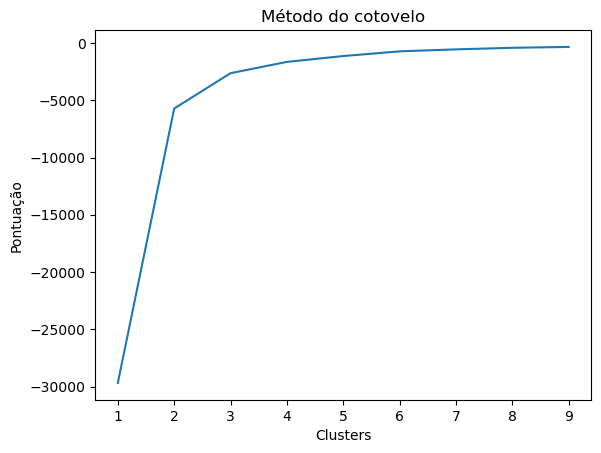

In [7]:
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(range(1,10), score)
plt.xlabel('Clusters')
plt.ylabel('Pontuação')
plt.title('Método do cotovelo')
plt.show()

Visualizando um número bom de clusters para inicialização do KMeans através do método do cotovelo. Nesse caso, estarei inicializando com 3, pois o gráfico indica que é um número ótimo de clusters. O método do cotovelo se concentra na variação dentro do cluster, ou seja, a soma das distâncias ao quadrado entre os pontos de dados e o centro do cluster (centroides). O ponto onde ocorre essa mudança é considerado o número ótimo de clusters, pois adicionar mais clusters não melhora significativamente a variância explicada.

Armazenando os centróides e os resultados obtidos após o treinamento e a predição do KMeans aplicado aos dados de Latitude e Longitude.

In [8]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X.iloc[:, 1:3])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X.iloc[:, 1:3])

Plotando os centróides no mapa e separando por cor cada cluster.

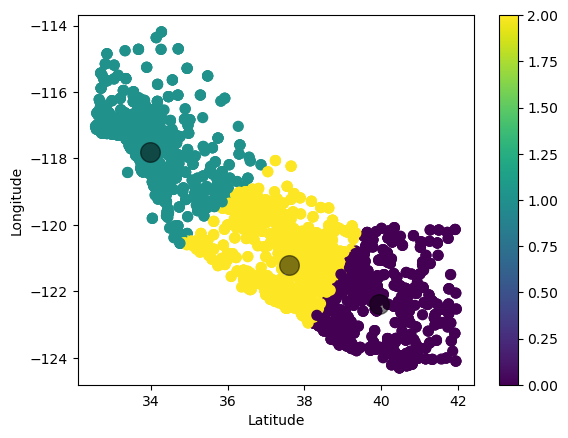

In [9]:
X.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [10]:
silhouette_scores = []

for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters = n_clusters, init ='k-means++')
    cluster_labels = kmeans.fit_predict(X)

    silhouette = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette)

    print(f"Para n_clusters = {n_clusters}, a média do coeficiente de silhueta é: {silhouette}")

Para n_clusters = 2, a média do coeficiente de silhueta é: 0.6265608305809072
Para n_clusters = 3, a média do coeficiente de silhueta é: 0.5898980147839606
Para n_clusters = 4, a média do coeficiente de silhueta é: 0.5714807499279632
Para n_clusters = 5, a média do coeficiente de silhueta é: 0.5604483481590874
Para n_clusters = 6, a média do coeficiente de silhueta é: 0.5526910430520644
Para n_clusters = 7, a média do coeficiente de silhueta é: 0.5477776427962184
Para n_clusters = 8, a média do coeficiente de silhueta é: 0.5429139942457986
Para n_clusters = 9, a média do coeficiente de silhueta é: 0.5396854819588307


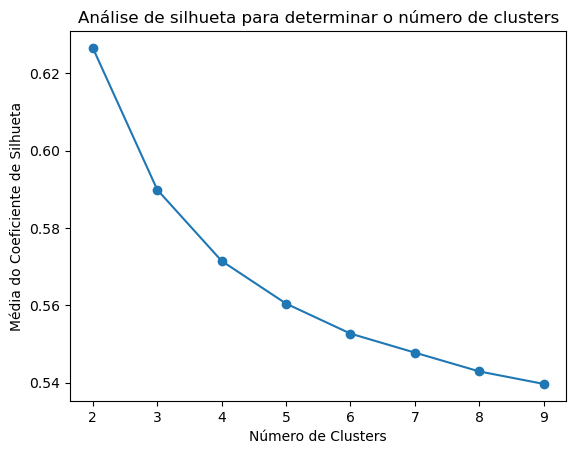

In [11]:
plt.plot(range(2,10), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Média do Coeficiente de Silhueta')
plt.title('Análise de silhueta para determinar o número de clusters')
plt.show()

A análise de silhueta mede a qualidade do agrupamento, calculando um score que leva em conta tanto a coesão dentro do cluster quanto a separação entre clusters diferentes. Para cada ponto, o coeficiente de silhueta é calculado com base na distância média do ponto para todos os outros pontos no mesmo cluster (coesão) e a distância média para os pontos no cluster mais próximo (separação).

Nesse caso, a análise de silhueta indica que 2 clusters seria um valor ótimo. Entretanto, irei considerar os 3 cluesters por estar juntando os dois métodos para realizar essa análise, e através do método do cotovelo, percebo que 3 seria um bom número.

In [12]:
kmeans = processing.KMeansCluster(n_clusters=3, columns_cluster= ['Latitude', 'Longitude'])
kmeans.fit(data)

KMeansCluster(columns_cluster=['Latitude', 'Longitude'],
              model_path='..\\preprocessing/kmeans_model.pkl')

In [13]:
X = kmeans.transform(data)

In [14]:
X['Cluster'].value_counts()

1    2304
2    1822
0     804
Name: Cluster, dtype: int64

In [15]:
X = X[['ID','Cluster']]

In [16]:
data = data.merge(X, left_on='ID', right_on='ID')
data.head()

,City,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,ID,Cluster
0,Stockton,37.954089,-121.329761,Male,No,No,No,57,Yes,No,...,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),74.35,4317.35,1,2
1,Grover Beach,35.120833,-120.618430,Male,No,Yes,Yes,1,Yes,No,...,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,19.75,19.75,2,2
2,Big Bar,40.775272,-123.287414,Female,No,No,No,54,Yes,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),100.05,5299.65,3,0
3,Laguna Beach,33.570023,-117.773669,Male,Yes,Yes,No,44,Yes,Yes,...,No,No,Yes,One year,No,Mailed check,88.40,3912.90,4,1
4,Fullerton,33.877639,-117.961212,Female,Yes,Yes,No,72,Yes,Yes,...,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),89.55,6448.85,5,1


In [17]:
unique_values= {col: data[col].unique() for col in data.columns}
for col, values in unique_values.items():
    print(f'Valores na coluna "{col}": {values}')
    print('--------------------------------------')

Valores na coluna "City": ['Stockton' 'Grover Beach' 'Big Bar' ... 'Quincy' 'Burney' 'Whitethorn']
--------------------------------------
Valores na coluna "Latitude": [37.954089 35.120833 40.775272 ... 34.11572  40.946785 40.053159]
--------------------------------------
Valores na coluna "Longitude": [-121.329761 -120.61843  -123.287414 ... -118.192754 -121.719489
 -123.995867]
--------------------------------------
Valores na coluna "Gender": ['Male' 'Female']
--------------------------------------
Valores na coluna "Senior Citizen": ['No' 'Yes']
--------------------------------------
Valores na coluna "Partner": ['No' 'Yes']
--------------------------------------
Valores na coluna "Dependents": ['No' 'Yes']
--------------------------------------
Valores na coluna "Tenure Months": [57  1 54 44 72  3 31 22 23 11 30  5 60 20 53 27 62 35 12 17 24  9 66 36
 10 71 37 34 50  8 47 40  4 15 41 28 59 13 45 58 49  2 48 42 64 63 65 68
 69 21 70 29  7 55 39 18 46 32 43 52 33 16 61 14 38 67 56 2

Agora, estarei testando diferentes combinações de pipeline e a aplicação das classes criadas para transformar os dados de diferentes formas/criar novas features que ajudem mais a decisão do modelo. 

Caso haja dúvidas sobre o que cada transformação faz, recomendo ir em '../automations/data_processing.py' que todas as classes estão documentadas explicando o que quis fazer.

In [18]:
pipeline_ohe = Pipeline([
    ('kmeans_cluster', processing.KMeansCluster(model_path='../preprocessing/kmeans_model.pkl', columns_cluster=['Latitude', 'Longitude'])),
    ('import_drop', processing.DropColumns(drop_columns=["City", "Latitude", "Longitude", "ID"])),
    ('service_transformer', processing.ServiceTransformer(["Multiple Lines", "Online Security", "Online Backup", "Device Protection", "Tech Support",
                                                     "Streaming TV", "Streaming Movies"])),
    ('categorical_encoder', processing.CategoricalEncoder(encoder_type='onehot', specified_columns=["Gender", "Senior Citizen", "Partner", "Dependents",
                                                                                                    "Phone Service", "Multiple Lines", "Internet Service",
                                                                                                    "Online Security", "Online Backup", "Device Protection",
                                                                                                    "Tech Support", "Streaming TV", "Streaming Movies", 
                                                                                                    "Contract", "Paperless Billing", "Payment Method",
                                                                                                    "Cluster"]))
])

O ServiceTransformer foi criado para os casos de aplicação do OneHotEnconder unicamente para não tornar o dataset com muitas colunas e aumentar a complexidade do mesmo. Porém, o correto seria manter todas as categorias e apenas retirar apenas uma categoria de cada feature. Como é um projeto apenas para fins didáticos, defini manter essa transformação. 

Será possível também, nos testes, utilizar o OneHotEncoder sem esse transformador.

In [19]:
data_ohe = pipeline_ohe.fit_transform(data)
data_ohe.head()

,Tenure Months,Monthly Charges,Total Charges,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Fiber optic,...,Device Protection_Yes,Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,57,74.35,4317.35,1,0,0,0,1,0,0,...,1,0,1,1,0,1,1,0,0,0
1,1,19.75,19.75,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,54,100.05,5299.65,0,0,0,0,1,0,1,...,0,0,1,1,1,0,1,1,0,0
3,44,88.40,3912.90,1,1,1,0,1,1,1,...,0,0,0,1,1,0,0,0,0,1
4,72,89.55,6448.85,0,1,1,0,1,1,0,...,1,1,1,1,0,1,1,1,0,0


In [20]:
unique_values= {col: data_ohe[col].unique() for col in data_ohe.columns}
for col, values in unique_values.items():
    print(f'Valores na coluna "{col}": {values}')
    print('--------------------------------------')

Valores na coluna "Tenure Months": [57  1 54 44 72  3 31 22 23 11 30  5 60 20 53 27 62 35 12 17 24  9 66 36
 10 71 37 34 50  8 47 40  4 15 41 28 59 13 45 58 49  2 48 42 64 63 65 68
 69 21 70 29  7 55 39 18 46 32 43 52 33 16 61 14 38 67 56 25 19  6 26 51
  0]
--------------------------------------
Valores na coluna "Monthly Charges": [ 74.35  19.75 100.05 ... 102.4   71.75  66.35]
--------------------------------------
Valores na coluna "Total Charges": [4317.35   19.75 5299.65 ... 4250.1  8075.35 1929.95]
--------------------------------------
Valores na coluna "Gender_Male": [1 0]
--------------------------------------
Valores na coluna "Senior Citizen_Yes": [0 1]
--------------------------------------
Valores na coluna "Partner_Yes": [0 1]
--------------------------------------
Valores na coluna "Dependents_Yes": [0 1]
--------------------------------------
Valores na coluna "Phone Service_Yes": [1 0]
--------------------------------------
Valores na coluna "Multiple Lines_Yes": [0 1

In [21]:
pipeline_le = Pipeline([
    ('kmeans_cluster', processing.KMeansCluster(model_path='../preprocessing/kmeans_model.pkl', columns_cluster=['Latitude', 'Longitude'])),
    ('import_drop', processing.DropColumns(drop_columns=['City', 'Latitude', 'Longitude', 'ID'])),
    ('categorical_encoder', processing.CategoricalEncoder(encoder_type='label'))
])

In [22]:
data_le = pipeline_le.fit_transform(data)
data_le.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Cluster
0,1,0,0,0,57,1,0,0,2,0,2,0,2,2,2,1,0,74.35,4317.35,2
1,1,0,1,1,1,1,0,2,1,1,1,1,1,1,0,0,2,19.75,19.75,2
2,0,0,0,0,54,1,0,1,2,2,0,0,2,2,1,1,1,100.05,5299.65,0
3,1,1,1,0,44,1,2,1,0,2,0,0,0,2,1,0,3,88.40,3912.90,1
4,0,1,1,0,72,1,2,0,2,2,2,2,2,2,2,1,1,89.55,6448.85,1


In [23]:
unique_values= {col: data_le[col].unique() for col in data_le.columns}
for col, values in unique_values.items():
    print(f'Valores na coluna "{col}": {values}')
    print('--------------------------------------')

Valores na coluna "Gender": [1 0]
--------------------------------------
Valores na coluna "Senior Citizen": [0 1]
--------------------------------------
Valores na coluna "Partner": [0 1]
--------------------------------------
Valores na coluna "Dependents": [0 1]
--------------------------------------
Valores na coluna "Tenure Months": [57  1 54 44 72  3 31 22 23 11 30  5 60 20 53 27 62 35 12 17 24  9 66 36
 10 71 37 34 50  8 47 40  4 15 41 28 59 13 45 58 49  2 48 42 64 63 65 68
 69 21 70 29  7 55 39 18 46 32 43 52 33 16 61 14 38 67 56 25 19  6 26 51
  0]
--------------------------------------
Valores na coluna "Phone Service": [1 0]
--------------------------------------
Valores na coluna "Multiple Lines": [0 2 1]
--------------------------------------
Valores na coluna "Internet Service": [0 2 1]
--------------------------------------
Valores na coluna "Online Security": [2 1 0]
--------------------------------------
Valores na coluna "Online Backup": [0 1 2]
----------------------

In [24]:
log_transformer = processing.LogTransformer(columns=['Total Charges'])
log_transformer.fit(data)

LogTransformer(columns=['Total Charges'])

In [25]:
pipeline_log = Pipeline([
    ('log_transformation', processing.LogTransformer(model_path='../preprocessing/log_transformer_model.pkl', columns=['Total Charges']))
])

In [26]:
data_log = pipeline_log.fit_transform(data)
data_log.head()

,City,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,ID,Cluster
0,Stockton,37.954089,-121.329761,Male,No,No,No,57,Yes,No,...,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),74.35,8.370629,1,2
1,Grover Beach,35.120833,-120.618430,Male,No,Yes,Yes,1,Yes,No,...,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,19.75,3.032546,2,2
2,Big Bar,40.775272,-123.287414,Female,No,No,No,54,Yes,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),100.05,8.575585,3,0
3,Laguna Beach,33.570023,-117.773669,Male,Yes,Yes,No,44,Yes,Yes,...,No,No,Yes,One year,No,Mailed check,88.40,8.272290,4,1
4,Fullerton,33.877639,-117.961212,Female,Yes,Yes,No,72,Yes,Yes,...,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),89.55,8.771812,5,1


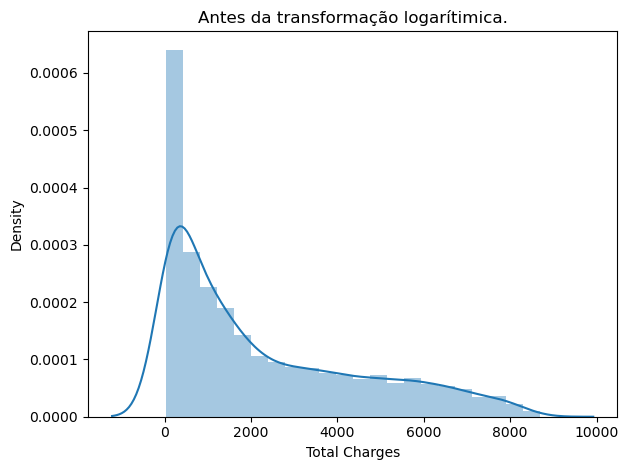

In [27]:
sns.distplot(data['Total Charges'])
plt.title('Antes da transformação logarítimica.')
plt.tight_layout()
plt.show()

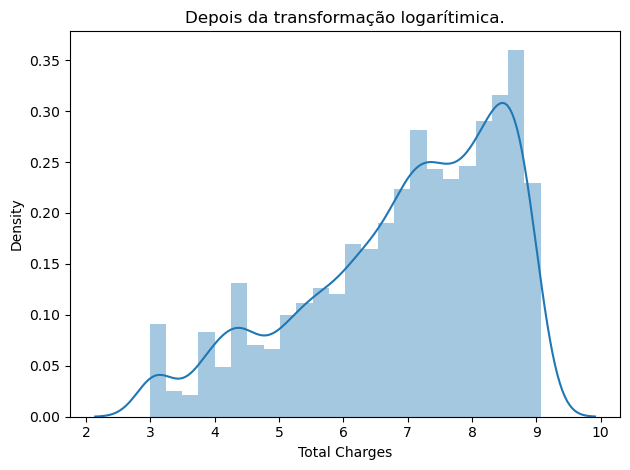

In [28]:
sns.distplot(data_log['Total Charges'])
plt.title('Depois da transformação logarítimica.')
plt.tight_layout()
plt.show()

In [29]:
boxcox_transformer = processing.BoxCoxTransformer(columns=['Total Charges'])
boxcox_transformer.fit(data)

BoxCoxTransformer(columns=['Total Charges'],
                  model_path='..\\preprocessing/boxcox_transformer_model.pkl')

In [30]:
pipeline_boxcox = Pipeline([
    ('boxcox_transformation', processing.BoxCoxTransformer(model_path='../preprocessing/boxcox_transformer_model.pkl', columns=['Total Charges']))
])

In [31]:
data_bx = pipeline_boxcox.fit_transform(data)
data_bx.head()

,City,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,ID,Cluster
0,Stockton,37.954089,-121.329761,Male,No,No,No,57,Yes,No,...,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),74.35,29.535808,1,2
1,Grover Beach,35.120833,-120.618430,Male,No,Yes,Yes,1,Yes,No,...,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,19.75,4.483993,2,2
2,Big Bar,40.775272,-123.287414,Female,No,No,No,54,Yes,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),100.05,31.343446,3,0
3,Laguna Beach,33.570023,-117.773669,Male,Yes,Yes,No,44,Yes,Yes,...,No,No,Yes,One year,No,Mailed check,88.40,28.701685,4,1
4,Fullerton,33.877639,-117.961212,Female,Yes,Yes,No,72,Yes,Yes,...,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),89.55,33.165552,5,1


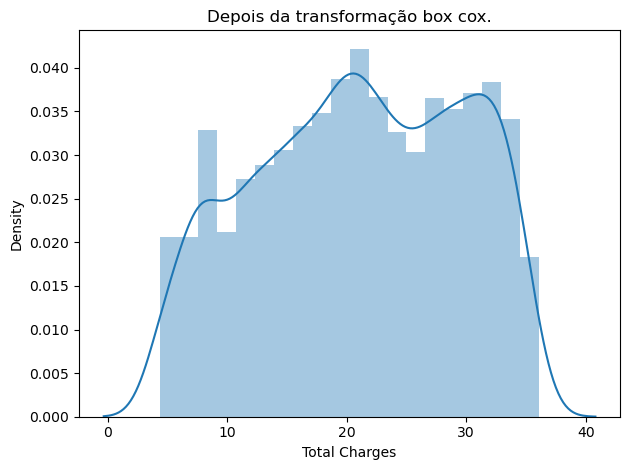

In [32]:
sns.distplot(data_bx['Total Charges'])
plt.title('Depois da transformação box cox.')
plt.tight_layout()
plt.show()

In [33]:
rbf_transformer = processing.RBFTransformer(column='Tenure Months', n_modes=2, gamma=0.1)
rbf_transformer.fit(data)

RBFTransformer(column='Tenure Months',
               model_path='..\\preprocessing/rbf_transformer_model.pkl')

O kernel RBF é uma função de similaridade que mede o quão próximos dois pontos estão no espaço de entrada, diminuindo exponencialmente com a distância. Isso permite capturar relações não-lineares complexas dentro dos dados. Essa técnica peguei de referência do livro "Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow", e foi utilizada por analisar que a coluna Tenure Months tem uma distribuição multimodal, e que podem ser muito importantes se tratadas de forma separada. 

De acordo com as visualizações, por exemplo, os clientes que tinham pouco tempo na companhia foram os que mais cancelaram, conforme esse tempo cresce, a taxa de cancelamento diminui.

In [34]:
pipeline_rbf = Pipeline([
    ('rbf_transformer', processing.RBFTransformer(column='Tenure Months', model_path='../preprocessing/rbf_transformer_model.pkl'))
])

In [35]:
data_rbf = pipeline_rbf.fit_transform(data)
data_rbf.head()

,City,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,ID,Cluster,Tenure Months_mode_0,Tenure Months_mode_1
0,Stockton,37.954089,-121.329761,Male,No,No,No,57,Yes,No,...,Yes,Two year,Yes,Bank transfer (automatic),74.35,4317.35,1,2,1.691898e-10,1.691898e-10
1,Grover Beach,35.120833,-120.618430,Male,No,Yes,Yes,1,Yes,No,...,No internet service,Month-to-month,No,Electronic check,19.75,19.75,2,2,1.180733e-219,1.180733e-219
2,Big Bar,40.775272,-123.287414,Female,No,No,No,54,Yes,No,...,Yes,One year,Yes,Credit card (automatic),100.05,5299.65,3,0,8.489044e-15,8.489044e-15
3,Laguna Beach,33.570023,-117.773669,Male,Yes,Yes,No,44,Yes,Yes,...,Yes,One year,No,Mailed check,88.40,3912.90,4,1,8.939487e-35,8.939487e-35
4,Fullerton,33.877639,-117.961212,Female,Yes,Yes,No,72,Yes,Yes,...,Yes,Two year,Yes,Credit card (automatic),89.55,6448.85,5,1,1.000000e+00,1.000000e+00
